In [1]:
from torch import optim
import torch.utils.data as data
from setting_model import *
import numpy as np
import os

CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Model instantiation
# forward_model = model
#forward_model = FC_Net_2D().to(device)

iteration = 0
interval = 100
batch_size = 100
lr = 0.0005     # 3e-4
epoch = 5000
iter_num = []
losses = {'err_train': [], 'err_test': [], 'loss_train': [], 'loss_test': []}

In [3]:
# Gets the relevant file path
data_root = os.getcwd()

train_trajectory_path = os.path.join(data_root, "Train_Data", "trajectory_38782.csv")
assert os.path.exists(train_trajectory_path), "{} path does not exist.".format(train_trajectory_path)

test_trajectory_path = os.path.join(data_root, "Train_Data", "trajectory_4310.csv")
assert os.path.exists(test_trajectory_path), "{} path does not exist.".format(test_trajectory_path)

# Save the updated weights file
#save_dir = os.path.join(data_root, "weight_optim")
#assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

In [4]:
# Loader Data
train_numpy = np.loadtxt(train_trajectory_path, delimiter=",")
train_input = torch.FloatTensor(train_numpy[:, 2000:2005]).to(device)
train_label = torch.FloatTensor(train_numpy[:, 0:2000]).to(device)
#train_input = train_input*1e6
train_label = train_label*1e6
train_dataset = data.TensorDataset(train_input, train_label)
data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    # 提取训练数据集并加载

test_numpy = np.loadtxt(test_trajectory_path, delimiter=",")
test_input = torch.FloatTensor(test_numpy[:, 2000:2005]).to(device)
test_label = torch.FloatTensor(test_numpy[:, 0:2000]).to(device)                               # 提取测试数据集
#test_input = test_input*1e6
test_label = test_label*1e6

In [5]:
train_numpy.shape

(38782, 2005)

In [6]:
# 第一阶段: 我们直接使用全连接层
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()
        self.layer1 = nn.Linear(5, 3200)                             # features=9       
        self.layer2 = nn.Linear(3200, 6400)
        self.layer3 = nn.Linear(6400, 4800)
        self.layer4 = nn.Linear(4800, 3200)
        self.layer5 = nn.Linear(3200, 2000)                   
        self.activation_1 = nn.LeakyReLU()
        self.activation_2 = nn.ReLU()

    def forward(self, inputs):
        x1 = self.activation_1(self.layer1(inputs))
        x2 = self.activation_1(self.layer2(x1))
        x3 = self.activation_1(self.layer3(x2))
        x4 = self.activation_1(self.layer4(x3))
        x5 = self.layer5(x4)
        return x5

forward_model = FC_Net().to(device)

In [7]:
a = torch.ones((10, 5)).to(device)
b = forward_model(a)
b.shape

torch.Size([10, 2000])

In [8]:
# Training process
def train():
    optimizer = optim.Adam(forward_model.parameters(), lr=lr)           # 添加正则化避免过拟合weight_decay=3e-5
    criterion = nn.MSELoss(reduction='mean')

    for t in range(epoch):
        for step, item in enumerate(data_loader):
            # train
            train_input, train_label = item
            train_predict = forward_model(train_input)
            loss_train = criterion(train_predict, train_label)
            
            global iteration                      # 声明全局变量， 不声明全局变量会报错
            if iteration % interval == 0:
                # test
                test_predict = forward_model(test_input)
                loss_test = criterion(test_predict, test_label)
                losses['loss_train'].append(loss_train.cpu().detach().numpy())
                losses['loss_test'].append(loss_test.cpu().detach().numpy())

                # compute and print the absolute error
                train_out = train_predict - train_label
                train_error = np.abs(train_out.cpu().detach().numpy()).mean()
                test_out = test_predict - test_label
                test_error = np.abs(test_out.cpu().detach().numpy()).mean()
                losses['err_train'].append(train_error)
                losses['err_test'].append(test_error)
                
                # 需要补充判断当Train_loss和Test_loss的最小时，保存此时的训练模型

                print('iteration: {}'.format(iteration))
                print('train_loss: {:.4}, test_loss: {:.4}'.
                      format(loss_train, loss_test))
                print('train_error: {:.4}, test_error: {:.4}'.
                      format(train_error, test_error))

                iter_num.append(iteration)


            # update parameters
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            iteration += 1

In [9]:
train()

iteration: 0
train_loss: 1.065, test_loss: 1.102
train_error: 0.7596, test_error: 0.7728
iteration: 100
train_loss: 0.5728, test_loss: 0.5709
train_error: 0.5222, test_error: 0.5203
iteration: 200
train_loss: 0.4798, test_loss: 0.5214
train_error: 0.4561, test_error: 0.4777
iteration: 300
train_loss: 0.4209, test_loss: 0.4287
train_error: 0.4119, test_error: 0.4223
iteration: 400
train_loss: 0.4862, test_loss: 0.4418
train_error: 0.4867, test_error: 0.4585
iteration: 500
train_loss: 0.4034, test_loss: 0.3907
train_error: 0.3867, test_error: 0.384
iteration: 600
train_loss: 0.3788, test_loss: 0.3893
train_error: 0.4031, test_error: 0.3981
iteration: 700
train_loss: 0.5103, test_loss: 0.4089
train_error: 0.4276, test_error: 0.3843
iteration: 800
train_loss: 0.2857, test_loss: 0.3653
train_error: 0.3393, test_error: 0.3713
iteration: 900
train_loss: 0.4284, test_loss: 0.3624
train_error: 0.413, test_error: 0.3684
iteration: 1000
train_loss: 0.2943, test_loss: 0.3489
train_error: 0.3305, t

KeyboardInterrupt: 

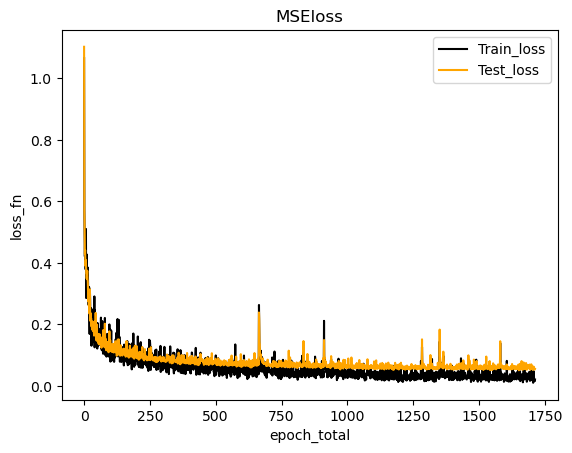

In [10]:
# MSEloss curve
Len = len(losses['loss_train'])
epoch_total = np.linspace(0, Len, Len)
plt.title('MSEloss')
plt.plot(epoch_total, losses['loss_train'],color="black", label='Train_loss')
plt.plot(epoch_total, losses['loss_test'],color="orange", label='Test_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch_total')
plt.ylabel('loss_fn')
plt.show()

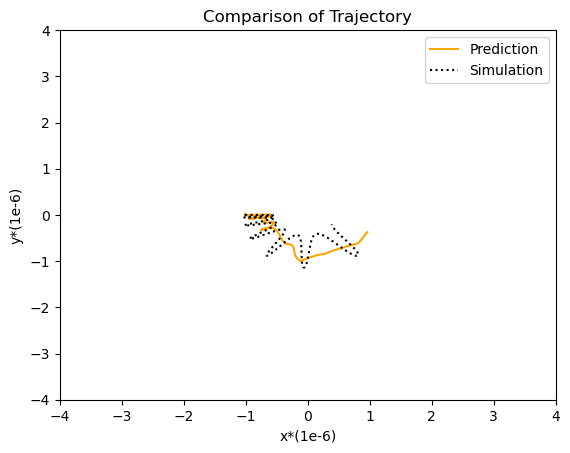

In [34]:
# 训练集预测效果
c = 911               # 82
valid_input = train_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 2000)               
valid_label = train_label[c].cpu().detach().numpy().reshape(1, 2000)                                    
valid_predict = valid_predict.reshape(2000,)
valid_label = valid_label.reshape(2000,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:1000], valid_predict[1000:2000], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:1000], valid_label[1000:2000], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

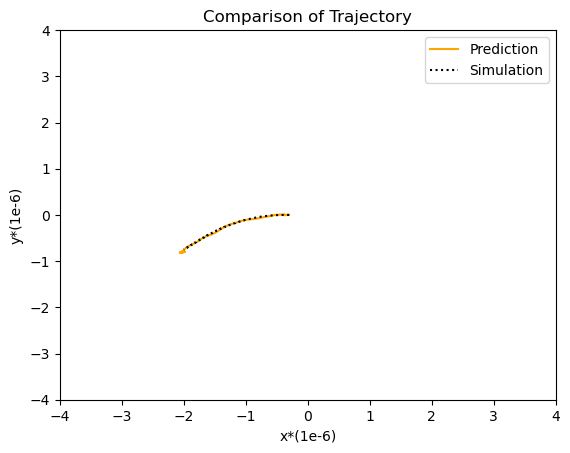

In [48]:
# 测试集预测效果
c = 117             # 10
valid_input = test_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 2000)               
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 2000)                                    
valid_predict = valid_predict.reshape(2000,)
valid_label = valid_label.reshape(2000,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:1000], valid_predict[1000:2000], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:1000], valid_label[1000:2000], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()